In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pydub.utils import json

# Importations

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# wakeword model

In [9]:
class LSTMWakeWord(nn.Module):

    def __init__(self, num_classes, feature_size, hidden_size,
                num_layers, dropout, bidirectional, device='cpu'):
        super(LSTMWakeWord, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.directions = 2 if bidirectional else 1
        self.device = device
        self.layernorm = nn.LayerNorm(feature_size)
        self.lstm = nn.LSTM(input_size=feature_size, hidden_size=hidden_size,
                            num_layers=num_layers, dropout=dropout,
                            bidirectional=bidirectional)
        self.classifier = nn.Linear(hidden_size*self.directions, num_classes)

    def _init_hidden(self, batch_size):
        n, d, hs = self.num_layers, self.directions, self.hidden_size
        return (torch.zeros(n*d, batch_size, hs).to(self.device),
                torch.zeros(n*d, batch_size, hs).to(self.device))

    def forward(self, x):
        # x.shape => seq_len, batch, feature
        x = self.layernorm(x)
        hidden = self._init_hidden(x.size()[1])
        out, (hn, cn) = self.lstm(x, hidden)
        out = self.classifier(hn)
        return out


In [10]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.1):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        outputs, (hidden, cell) = self.lstm(x)
        # outputs: (batch_size, seq_len, hidden_size)
        # hidden: (num_layers, batch_size, hidden_size)
        # cell: (num_layers, batch_size, hidden_size)
        return outputs, hidden, cell

In [11]:
class DecoderLSTM(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers=1, dropout=0.1):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden, cell):
        # input: (batch_size)
        input = input.unsqueeze(1)  # (batch_size, 1)
        embedded = self.embedding(input)  # (batch_size, 1, hidden_size)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output.squeeze(1))  # (batch_size, output_size)
        return prediction, hidden, cell


In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features
        
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        encoder_outputs, hidden, cell = self.encoder(src)
        
        input = trg[:, 0]
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
        
        return outputs

# Creation des DataLoader

In [5]:
# Diviser X et y en un ensemble d'entraînement (80%) et un ensemble de validation (20%)
X = np.load("data/mfcc_feature.npy")
y = np.load("data/labels.npy")

X_train, X_set, y_train, y_set = train_test_split(X, y, test_size=0.2, random_state=34)
X_valid, X_test, y_valid, y_test = train_test_split(X_set, y_set, test_size=0.5, random_state=34)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_valid = X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# Définir les hyperparamètres
input_size = X_train.shape[2]  # Nombre de coefficients MFCC
hidden_size = 1024  # Taille de la couche cachée
num_classes = y.shape[0]  # Nombre de classes (mots/phrases)
num_epochs = 120
batch_size = len(X_train)
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convertir les données en tensors PyTorch
X_train_tensor = torch.Tensor(X_train)
X_valid_tensor = torch.Tensor(X_valid)
X_test_tensor = torch.Tensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_valid_tensor = torch.LongTensor(y_valid)
y_test_tensor = torch.LongTensor(y_test)

# Créer des DataLoader PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(X_valid), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=True)

# Enregistrement des hyper parametres du modele

In [6]:
model_parameters = {
    "input_size": input_size,
    "hidden_size": hidden_size,
    "num_classes": num_classes,
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "learning_rate": learning_rate
}

with open("data/model_parameters.json", "w", encoding="utf-8") as f:
    json.dump(model_parameters, f, indent=4, ensure_ascii=False)

In [7]:
with open("data/model_parameters.json", "r", encoding="utf-8") as f:
    data = json.load(f)
    print(data)

{'input_size': 494, 'hidden_size': 1024, 'num_classes': 3000, 'num_epochs': 120, 'batch_size': 2400, 'learning_rate': 0.001}


# Model LSTM + RNN

In [8]:
class ActDropNormRNN(nn.Module):
    def __init__(self, n_feats, dropout, keep_shape=False):
        super(ActDropNormRNN, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(n_feats)
        self.keep_shape = keep_shape
    
    def forward(self, x):
        x = x.transpose(1, 2)
        # x = self.norm(self.dropout(F.gelu(x)))
        x = self.dropout(F.gelu(self.norm(x)))
        if self.keep_shape:
            return x.transpose(1, 2)
        else:
            return x


class SpeechRecognition(nn.Module):

    def __init__(self, hidden_size, num_classes, n_feats, num_layers, dropout):
        super(SpeechRecognition, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = ModelRNN(n_feats, hidden_size)  # Utilisation du RNN personnalisé
        self.dense = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.LayerNorm(input_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(input_size, input_size),
            nn.LayerNorm(input_size),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, dropout=0.0,
                            bidirectional=False)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.dropout2 = nn.Dropout(dropout)
        self.final_fc = nn.Linear(hidden_size, num_classes)

    def _init_hidden(self, batch_size):
        n, hs = self.num_layers, self.hidden_size
        return (torch.zeros(n*1, batch_size, hs),
                torch.zeros(n*1, batch_size, hs))

    def forward(self, x, hidden):
        x = x.squeeze(1)  # batch, feature, time
        x = self.rnn(x)  # batch, time, hidden_size
        x = self.dense(x) # batch, time, feature
        x = x.transpose(0, 1) # time, batch, feature
        out, (hn, cn) = self.lstm(x, hidden)
        # Ajustement des dimensions de hx et cx
        hn = hn.squeeze(0)  # hn devient 2D
        cn = cn.squeeze(0)  # cn devient 2D
        x = self.dropout2(F.gelu(self.layer_norm2(out)))  # (time, batch, n_class)
        return self.final_fc(x), (hn, cn)

class ModelRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ModelRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        out, _ = self.rnn(x)
        return out

class ModelLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(ModelLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.final_fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, hidden):
        out, (hn, cn) = self.lstm(x, hidden)
        x = self.dropout(F.gelu(self.layer_norm(out)))  # Shape: batch_size, time_steps, hidden_size
        return self.final_fc(x), (hn, cn)

# Fonction pour calculer la précision

In [9]:
def accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs, _ = model(inputs.unsqueeze(1), model._init_hidden(inputs.size(0)))
            _, predicted = torch.max(outputs.squeeze(0).data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# entraînement du modèle de classification vocale en utilisant PyTorch et les caractéristiques MFCC

In [13]:
# Définition du modèle
model = SpeechRecognition(hidden_size=hidden_size, num_classes=num_classes, n_feats=input_size, num_layers=1, dropout=0.1)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss = []
train_acc = []
test_loss = []
test_acc = []
best_train_acc = 0
best_test_acc = 0
# Entraînement du modèle
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(inputs.unsqueeze(1), model._init_hidden(inputs.size(0)))  # Ajout de unsqueeze(1) pour correspondre à la taille du batch
        loss = criterion(outputs.squeeze(), labels)  # Ajustement pour correspondre à la taille du batch
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        acc = accuracy(train_loader, model)

    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    train_acc.append(acc)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs, _ = model(inputs.unsqueeze(1), model._init_hidden(inputs.size(0)))
            loss = criterion(outputs.squeeze(), labels)
            _, predicted = torch.max(outputs.squeeze(0).data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc1 = correct / total
    test_loss.append(loss)
    test_acc.append(acc1)

    # record best train and test
    if acc > best_train_acc:
        best_train_acc = acc
    if acc1 > best_test_acc:
        best_test_acc = acc1

print(f'valid_loss = {100 * loss / total : .3}% \nvalid_acc = {100 * best_test_acc : .3}%')
print("Entraînement terminé.")
# Sauvegarder le modèle entraîné
torch.save(model.state_dict(), 'data/model.pth')

100%|██████████| 120/120 [13:48<00:00,  6.91s/it]


valid_loss =  0.768% 
valid_acc =  12.7%
Entraînement terminé.


# Affichage du courbe d'apprentissage

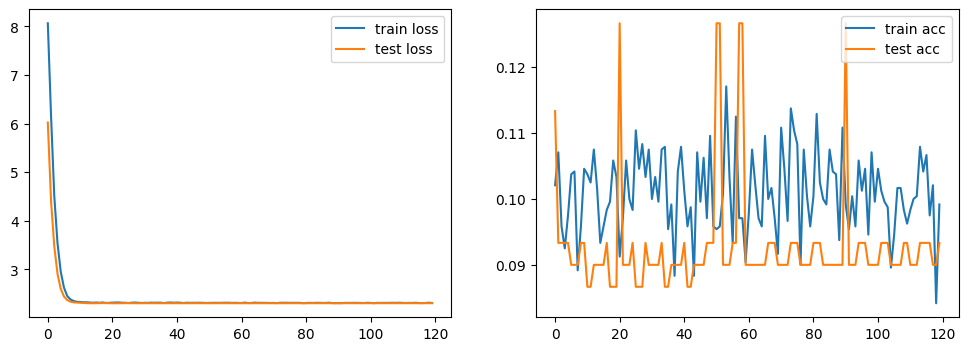

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="train acc")
plt.plot(test_acc, label="test acc")
plt.legend()
plt.show()

# Accuracy sur les données de test

In [15]:
# Charger le modèle entraîné s'il n'a pas déjà été chargé
model = SpeechRecognition(hidden_size=hidden_size, num_classes=num_classes, n_feats=input_size, num_layers=1, dropout=0.1)
model.load_state_dict(torch.load('model.pth'))

# Mettre le modèle en mode évaluation
model.eval()

# Calculer la précision sur l'ensemble de donnée de test
accuracy_test = accuracy(test_loader, model)
print(f"Précision sur l'ensemble de test : {100*accuracy_test:.2f}%")


Précision sur l'ensemble de test : 8.67%


# Tokenisation et création du vocabulaire

In [11]:

with open("data/audio_path.json", "r", encoding="utf-8") as f:
    transcriptions = json.load(f)

labels = np.array([transcription["transcription"] for transcription in transcriptions])
data = labels

vocabularies = []
word_to_index = {}
index_to_word = {}
for sentence in data:
    tokens = sentence.split()
    for token in tokens:
        if token not in word_to_index:
            word_to_index[token] = len(word_to_index)
            index_to_word[len(index_to_word)] = token
            vocabularies.append(token)

# Encodage des séquences
encoded_data = []
for sentence in data:
    tokens = sentence.split()
    encoded_sentence = [word_to_index[token] for token in tokens]
    encoded_data.append(encoded_sentence)


# Création du Dataset et DataLoader
class LanguageDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index])


dataset = LanguageDataset(encoded_data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

with open("data/labels.json", "w") as f:
    for vocabulary in vocabularies:
        json.dump(vocabulary, f, ensure_ascii=False, indent=4)


['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'height', 'nine']


# Décodage

(1, 1, 494)
torch.Size([1, 1, 3000])
Texte transcrit : seven


In [13]:
# Charger le modèle entraîné
model = SpeechRecognition(hidden_size=hidden_size, num_classes=num_classes, n_feats=input_size, num_layers=1, dropout=0.1)
model.load_state_dict(torch.load('model.pth'))
model.eval()

# Définir le décodeur
def decode_output(output, vocab):
    decoded_sequence = []
    for timestep_output in output:
        predicted_symbol_index = torch.argmax(timestep_output).item()
        predicted_symbol = vocab[predicted_symbol_index]
        decoded_sequence.append(predicted_symbol)
    return ' '.join(decoded_sequence)

# Utiliser le modèle pour transcrire l'audio
with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs, _ = model(inputs.unsqueeze(1), model._init_hidden(inputs.size(0)))
        decoded_text = decode_output(outputs.squeeze(), vocab)
        print("Texte transcrit :", decoded_text)

Texte transcrit : nine one one zero three height six height height three nine three one two four six nine five four four three two five four four two height six four two four five seven six nine height three one one six one seven two height one nine one nine five six five two five nine three five four nine zero four seven five zero five six six six seven seven two four four nine five six nine one six six zero seven seven one two two seven three two one seven height zero six three zero six six six six three height four seven five five three height six six six nine nine zero three three four two nine zero four two six four three two four six three zero three zero two seven five two seven nine two seven six three two five height one two height nine height height three five height height three three three nine two six four five seven three five height seven two five nine seven two height height three one height one nine zero one height five four five one five one two zero five four three o

In [ ]:
# 1. Charger le modèle
model = SpeechRecognition(hidden_size=hidden_size, num_classes=num_classes, n_feats=input_size, num_layers=1, dropout=0.1)
model.load_state_dict(torch.load('model.pth'))
model.eval()

# 2. Prétraiter les données audio
X = np.load("mfcc_feature1.npy")
X = X.reshape(X.shape[0], 1, X.shape[1])
print(X.shape)
X_tensor = torch.Tensor(X)

# Si vous utilisez GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
X_tensor = X_tensor.to(device)

# Obtenir les prédictions
with torch.no_grad():
    outputs, _ = model(X_tensor.unsqueeze(1), model._init_hidden(X_tensor.size(0)))

# Appliquer la fonction softmax si nécessaire
probs = F.softmax(outputs, dim=1)
predictions = torch.argmax(probs, dim=1)

# Faire quelque chose avec les prédictions
print("Prédictions:", predictions)

(3000, 1, 494)
Prédictions: tensor([[ 271,  496,  697,  ..., 1578, 1544, 1146]])


In [ ]:
model = LSTMWakeWord(num_classes, input_size, hidden_size, 1, 0.001, False, device=device)

/home/hubs/.local/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.001 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Exemple de données texte
texts = ["Ceci est un exemple de phrase.", "Voici un autre exemple."]

# Initialiser le CountVectorizer
vectorizer = CountVectorizer(binary=True)

# Adapter le vectorizer aux données et encoder les données texte
encoded_texts = vectorizer.fit_transform(texts)

# Afficher les textes encodés
print(encoded_texts.toarray())

[[0 1 1 1 1 1 1 0]
 [1 0 0 0 1 0 1 1]]


In [ ]:
# Évaluation du modèle (exemples de prédiction)
input_test = torch.tensor([[word_to_index["one"], word_to_index["three"], word_to_index["three"], word_to_index["three"], word_to_index["one"]]])
output_test = model(input_test)
predicted_index = torch.argmax(output_test)
predicted_word = index_to_word[predicted_index.item()]
print('Predicted Word:', predicted_word)

RuntimeError: mixed dtype (CPU): all inputs must share same datatype.

# Utils

In [ ]:
class TextProcess:
	def __init__(self):
		char_map_str = """
		' 0
		<SPACE> 1
		a 2
		b 3
		c 4
		d 5
		e 6
		f 7
		g 8
		h 9
		i 10
		j 11
		k 12
		l 13
		m 14
		n 15
		o 16
		p 17
		q 18
		r 19
		s 20
		t 21
		u 22
		v 23
		w 24
		x 25
		y 26
		z 27
		"""
		self.char_map = {}
		self.index_map = {}
		for line in char_map_str.strip().split('\n'):
			ch, index = line.split()
			self.char_map[ch] = int(index)
			self.index_map[int(index)] = ch
		self.index_map[1] = ' '

	def text_to_int_sequence(self, text):
		""" Use a character map and convert text to an integer sequence """
		int_sequence = []
		for c in text:
			if c == ' ':
				ch = self.char_map['<SPACE>']
			else:
				ch = self.char_map[c]
			int_sequence.append(ch)
		return int_sequence

	def int_to_text_sequence(self, labels):
		""" Use a character map and convert integer labels to an text sequence """
		string = []
		for i in labels:
			string.append(self.index_map[i])
		return ''.join(string).replace('<SPACE>', ' ')


textprocess = TextProcess()

def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2)
	decodes = []
	targets = []
	for i, args in enumerate(arg_maxes):
		decode = []
		targets.append(textprocess.int_to_text_sequence(
				labels[i][:label_lengths[i]].tolist()))
		for j, index in enumerate(args):
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j -1]:
					continue
				decode.append(index.item())
		decodes.append(textprocess.int_to_text_sequence(decode))
	return decodes, targets

# Decoder

In [ ]:
labels = [
    "'",  # 0
    " ",  # 1
    "a",  # 2
    "b",
    "c",
    "d",
    "e",
    "f",
    "g",
    "h",
    "i",
    "j",
    "k",
    "l",
    "m",
    "n",
    "o",
    "p",
    "q",
    "r",
    "s",
    "t",
    "u",
    "v",
    "w",
    "x",
    "y",
    "z",  # 27
    "_",  # 28, blank
]

def DecodeGreedy(output, blank_label=28, collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2).squeeze(1)
	decode = []
	for i, index in enumerate(arg_maxes):
		if index != blank_label:
			if collapse_repeated and i != 0 and index == arg_maxes[i -1]:
				continue
			decode.append(index.item())
	return textprocess.int_to_text_sequence(decode)

class CTCBeamDecoder:

    def __init__(self, beam_size=100, blank_id=labels.index('_'), kenlm_path=None):
        print("loading beam search with lm...")
        self.decoder = ctcdecode.CTCBeamDecoder(
            labels, alpha=0.522729216841, beta=0.96506699808,
            beam_width=beam_size, blank_id=labels.index('_'),
            model_path=kenlm_path)
        print("finished loading beam search")

    def __call__(self, output):
        beam_result, beam_scores, timesteps, out_seq_len = self.decoder.decode(output)
        return self.convert_to_string(beam_result[0][0], labels, out_seq_len[0][0])

    def convert_to_string(self, tokens, vocab, seq_len):
        return ''.join([vocab[x] for x in tokens[0:seq_len]])
